# Crime Data Validation Practices

In [41]:
library(ggplot2)
library(ggmap)
library(ggplot2)
library(maps)
library(plyr)
suppressMessages(library(lubridate))
library(repr)

Garbage in, garbage out: If the data that we bring into our system is bad, our model is going to be bad. In the end, much of the quality in our tool is dependent on the quality of our initial data. Sometimes we can do things to produce a good model from poor quality data, but we'd rather not if possible. This notebook outlines the data validation that CivicScape undertakes when importing new crime data or updating existing crime data. We want to ensure we have answers to the following key questions before using data in our model.

*  What is the distribution of the data? 
*  Is this data consistent over time? 
*  Is this data missing key elements that we need for models? 


#### Why does this matter? 
Erroneous, biased or missing data can impact the results of a model's output. In other words, if missing or erroneous data were used in a model, the end result would on average be wrong. Many sources provide additional information about the importance of initial data analysis to guard against these kind of problems (see Riley, 2016; Higgins, Altman and Sterne, 2011). What they share is an emphasis on the importance of understanding where your data comes from, how it was generated, if it measures what you think it is measuring, and if there are problematic inconsistencies, errors, or missing data.  Data is ultimately the recording of human actions by humans, so it can be prone to error that is important to recognize (Crawford, 2014).

While many cities offer crime data online, and many jurisdictions record crime data, that doesn't always mean that the data are *high quality*. Poor quality data, meaning data that is systematically missing observations or important categories, can result from any number of reasons such as flawed data storage or human error. Crime data in particular is prone to human error because it is a compilation of reports that come from a variety of sources- 911 calls for service, arrests, and police reports among others. Importantly, the source of these data are people filing reports, making an arrest, or recording information about these events. 

Just as that process can introduce some inconsistency, so too can the process of recording data. Databases of reports are often depedent on a person entering the data, which introduces the possibility for human error in the entry. And even if the process has been automated with a computer, might the computer fail to update one week? If this occurs, is the error noticed and corrected before the reports are compiled into the data delivered to the risk assessment model? We find that often in source data, we are missing a month of data, or a field that hasn't been filled out on a significant number of rows in the data. 

It's imperative that we check the data for errors, outliers, and consistent distributions so that we know what they are at the outset and take steps to address them before we run our models. The process below is a snapshot of the considerations we implement when evaluating the raw crime data by jurisdiction to validate the data we use in our models:

* Crime event data
* 311 calls for service data (where available)
* Geographic information about where the crime occurred
* Time of the crime occurrence 

### To Begin: Please enter the path for the crime data you wish to analyze.

In [42]:
# Enter location of dataset
data<- read.csv("path/to/data.csv")


### Type of Report

The type of record(s) that comprise the source crime data can provide key insight into how to evaluate the data for important distributions or missing data. This is because crime reports originate from disparate sets of records, such as an incident or arrest report. Often, the type of record(s) used also vary from jurisdiction to jurisdiction. For example, New Orleans provides open 911 reports, with a field that reports whether the call was then confirmed to be a crime. Meanwhile, Chicago aggregates crime reports and arrest reports into one table in their open data portal, and provide a field denoting whether the report was related to an arrest report or an incident report. 

In our data, we define a field ReportType, and populate this column with information on the type of report. If this information is not provided by the jurisdiction, then we do not populate this column, and instead move on to the next step to for additional assessment of data quality. 

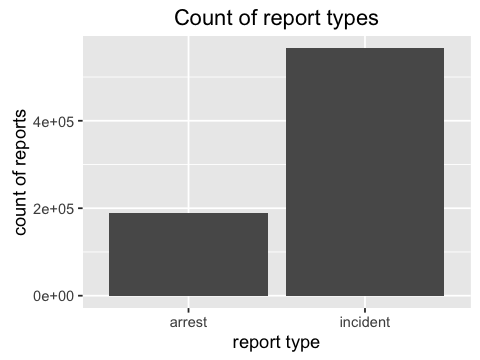

In [43]:
options(repr.plot.width=4, repr.plot.height=3)
theme_set(theme_gray(base_size = 11))
qplot(data$report_type, xlab="report type", ylab="count of reports", main="Count of report types")



### Type of Crime Data 

It is also important to know what kind of crime data is present in our dataset. We can examine the types of crime below in tables. We want to make sure that crime types that we need are present in order to be able to examine different crime types. 


In [44]:
## what are the most populous crime types in your data? 
head(sort(table(data$crime_type_a),decreasing = TRUE), n=20)
head(sort(table(data$crime_type_b),decreasing = TRUE), n=20)



 0820  0486  0460  0810  1320  1310  0560  1811  0610  0910  0860  0890  0620 
73457 69850 45824 39862 38967 37891 33233 26590 24372 24340 23766 22967 12477 
 2820  1330  031A  1153  0320  2024  1150 
12102 11448 10912 10911 10093 10016  8622 


                           THEFT                          BATTERY 
                          168789                           140498 
                 CRIMINAL DAMAGE                        NARCOTICS 
                           82190                            63256 
                         ASSAULT                    OTHER OFFENSE 
                           49688                            48545 
              DECEPTIVE PRACTICE                         BURGLARY 
                           44236                            39105 
             MOTOR VEHICLE THEFT                          ROBBERY 
                           29083                            28965 
               CRIMINAL TRESPASS                WEAPONS VIOLATION 
                           19220                             9317 
          PUBLIC PEACE VIOLATION       OFFENSE INVOLVING CHILDREN 
                            6686                             6471 
             CRIM SEXUAL ASSAULT                     PROSTITU

### Distribution of Crime Data

We not only care about the distribution of crime events and reports by type, but also about the distribution of different types across the jurisdiction so we can understand if there are problematic patterns of missing or underreported crime data. Are arrests more common in particular neighborhoods compared to the average? For a particular crime? Are we missing all incidents from a particular area of the jurisdiction? Are 911 calls more frequent in some parts of the jurisdiction than others? 

The most approachable way to dive into this question is to start by inspecting the distribution of crime across the jurisdiction, by report type and crime type. 

To generate maps to examine these questions, run the scripts below to first examine the distribution of report types and then crime types. 

In [ ]:
## Map types of crime_reports, if applicable 
jurisdiction <- "Enter Your Jurisdiction Here"
state <- "Enter your state here"
report_type <- "Enter a report_type - i.e. incident"

jurisdiction <- "chicago"
state <- "il"
report <- "arrest"

#
basemap <- get_map(location = paste(jurisdiction, " ,", state, sep=""), zoom=11, maptype='roadmap', source='google')
#
reports <- subset(data, report_type = paste0(report))
reports <-count(reports, c('lat', 'long')) 
names(reports) <- c('lat', 'long', 'Frequency')
reports$long <- as.numeric(as.character(reports$long))
reports$lat <- as.numeric(as.character(reports$lat))
reports <- subset(reports, Frequency > 0)

ggmap(basemap) + geom_tile(data = reports, aes(x = lat, y = long, alpha = Frequency),
                           fill = 'red') + theme(axis.title.y = element_blank(), axis.title.x = element_blank())


For the crime types map, select a crime type from the tables above and enter it to examine its distribution across the selected jurisdiction.

In [ ]:
## Map types of crime or all crime
jurisdiction <- "Enter Your Jurisdiction Here"
state <- "Enter your state here"
crime_type <- "Enter a crime_type - i.e. ROBBERY"

jurisdiction <- "chicago"
state <- "il"
crime_type <- "WEAPONS VIOLATION"

#first we load the map of the jurisdiction selected above
basemap <- get_map(location = paste(jurisdiction, " ,", state, sep=""), zoom=11, maptype='roadmap', source='google')
#select the crime type 
types <- as.data.frame(table(data$long[data$crime_type_b==paste0(crime_type)], 
                              data$lat[data$crime_type_b==paste0(crime_type)]))
names(types) <- c('long', 'lat', 'Frequency')
types$long <- as.numeric(as.character(types$long))
types$lat <- as.numeric(as.character(types$lat))
types <- subset(types, Frequency > 0)
#plot map of crimetype 
ggmap(basemap) + geom_tile(data = types, aes(x = lat, y = long, alpha = Frequency),
                           fill = 'red') + theme(axis.title.y = element_blank(), axis.title.x = element_blank())


### Consistency and Missing-ness of Crime Data

Another consideration around the quality and useability of the source data is whether there is any missing data. And, if there is missing data, is it significant in that we expect it should impact the results of our risk assessments? 

#### Visually inspecting for missing data

To ensure we do not use data that is missing or problematic, we first use visual checks to view whether any data is missing, and if so, where it appears to be missing. Specifically, below, we look at whether our data visually suggests that there might be data missing by: 

1. Hour
2. Day of the Week
3. Month
4. Year
5. Crime types over time

We visually inspect the full sample of all data, and then each crime type to uncover quality issues within a data type that may not be immediately clear. It also enables us to better compare to expected levels and understand if our data is inconsistent in a way that biases our model. We test these visual findings in the subsequent section. 

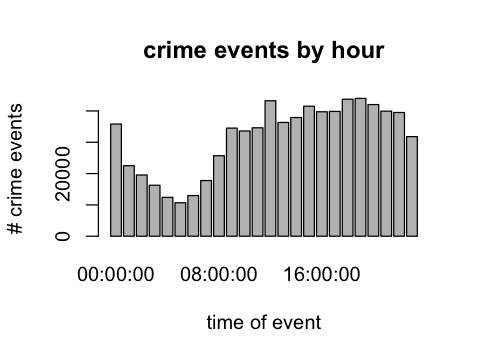

In [52]:
#first format the date field as a date to plot events over time 
data$date <- ymd(data$date)

byhour <- table(data$time)
barplot(byhour, ylab = "# crime events", xlab = "time of event", main = "crime events by hour")


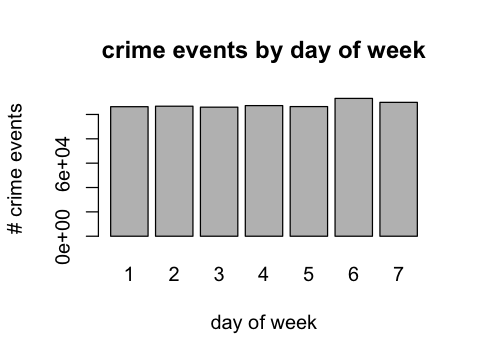

In [53]:
byday <- table(wday(data$date))
barplot(byday, ylab = "# crime events", xlab = "day of week", main = "crime events by day of week")



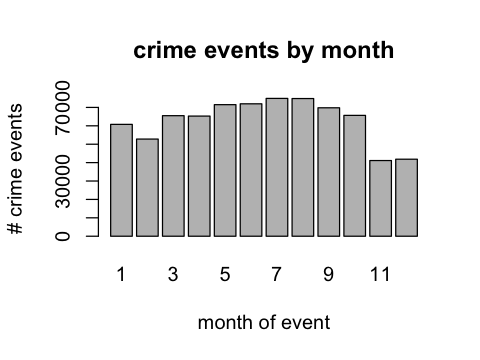

In [49]:
bymonth <- table(month(data$date))
barplot(bymonth, ylab = "# crime events", xlab = "month of event", main = "crime events by month")


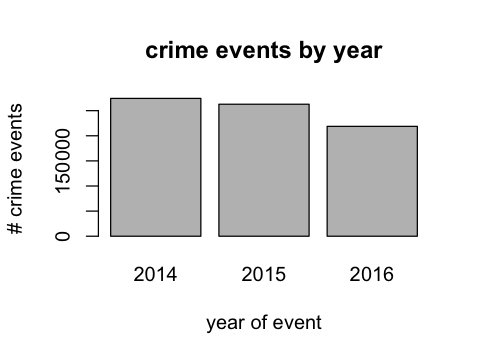

In [50]:
byyear <- table(year(data$date))
barplot(byyear, ylab = "# crime events", xlab = "year of event", main = "crime events by year")


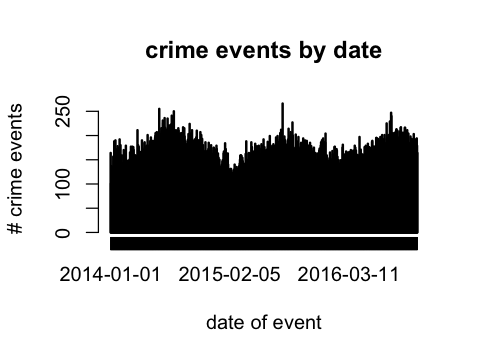

In [51]:

# crime_type over time 
crime_type <- "Enter a crime_type from your table above"
crime_type<- "THEFT"

plot(table(data$date[data$crime_type_b==paste0(crime_type)]), ylab = "# crime events", xlab = "date of event", main = "crime events by date")



### Can we use this data in our models? 

The plots and tables above can help uncover problematic missing data and answer important questions including: 

* Does the distribution of crime data match the pattern you expect? 
* Is the distribution consistent over time? 
* Are there years or months for which there appears to be no data at all? 
* Are there hours that appear to have no reports? 
* Are there crimes for which we do not have a location? 

Ensuring that the data we use is not missing important crimes, times, or locations is a vital part of understanding whether or not the data we are inputting to our models for risk assessment are usable.  When we encounter data that is, for instance, systematically missing all hour timestamps, or we see data where all arrests occurred at 00:00:00, we do not use it in our models -- instead, we notify our jurisdiction partners to provide them with our analysis to help improve crime data collection. We likewise routinely reject low level crime data on drug arrests, for example, for their inability to match distribution expectations. 

Ultimately, the decision about whether or not to use data in models is a combination of judgement and science. Judgement enters the picture because we can use knowledge about how crime data is collected to assess whether or not is usable. For instance, perhaps a jurisdiction is systematically switching their data entry for latitute and longitide -- we can help identify and correct that error. Scientifically, we can assess at what point missing data starts to impact our model's accuracy and precision. 

By sharing a snapshot of our internal process, we aim provide resources to law enforcement and communities that can be replicated, building trust and transparency about when we can use crime data in algorithms.  

If you are interested in learning more about how we evaluate crime data, please refer to our working paper on the topic of bias in crime data. We strive to update our research and methods as new research is made available on the topic. If you are interested in getting more detail on the data decisions we made from this procedure for each jurisdiction for which we have assessed crime risk thus far, please refer to the database information for that jurisdiction, available in our Training_and_Testing directory on our public Github page. 




### References 

1. Crawford, Kate. "The Hidden Bias in Big Data." Harvard Business Review. Available: https://hbr.org/2013/04/the-hidden-biases-in-big-data 
2. Higgins, Julian PT; Altman, Douglas G., Sterne, Jonathan AC. "Assessing Risk of Bias in Included Studies." Cochrane Handbook for Systmatic Review of Interventions. Cochrane Statistical Methods Group and the Cochrane Bias Methods Group.  March 2011. Available:  http://handbook.cochrane.org/chapter_8/8_assessing_risk_of_bias_in_included_studies.htm
3. Riley, Patrick. "Practical advice for analysis of large, complex data sets." October 31, 2016. Unofficial Google Data Science Blog. Available: http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html


